# Covid19 Chest Xray Classifier Tutorial

## 0. Common Imports

In [2]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
torch.manual_seed(3)

from PIL import Image
from torchvision import transforms as T

## 1. Prepare Training Set & Test Set

In [3]:
ROOT_DIR = os.path.abspath('.')
DATA_DIR = os.path.join(ROOT_DIR, 'datasets')
TEST_DIR = os.path.join(DATA_DIR, 'test')
classes = ['normal', 'viral', 'covid']

for class_ in classes:
    start_dir = os.path.join(DATA_DIR, class_)
    target_dir = os.path.join(TEST_DIR, class_)
    os.makedirs(target_dir, exist_ok=True)
    images = os.listdir(start_dir)
    images = [image for image in images if image.lower().endswith('png')]
    sampled_images = random.sample(images, 30)
    for image in sampled_images:
        start_path = os.path.join(start_dir, image)
        target_path = os.path.join(target_dir, image)
        shutil.move(start_path, target_path)

## 2. Define Custom Dataset

In [4]:
class CovidCXRDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        self.images = {}
        self.classes = ['normal', 'viral', 'covid']
        self.image_dirs = image_dirs
        self.transform = transform
        
        for class_ in classes:
            self.images[class_] = self.get_images(class_)
    
    def get_images(self, class_):
        images = os.listdir(self.image_dirs[class_])
        images = [image for image in images 
                  if image.lower().endswith('png')]
        
        print(f'Found {len(images)} {class_} examples')
        return images
    
    def __len__(self):
        return sum([len(self.images[class_])
                    for class_ in self.classes])
    
    def __getitem__(self, index):
        sampled_class = random.choice(self.classes)
        n_samples = len(self.images[sampled_class])
        
        index = index % n_samples
        image_name = self.images[sampled_class][index]
        image_dir = self.image_dirs[sampled_class]
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.classes.index(sampled_class)

## 3. Create DataLoader

In [5]:
train_transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
test_transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [6]:
train_dirs = {
    'normal': os.path.join(DATA_DIR, 'normal'),
    'viral': os.path.join(DATA_DIR, 'viral'),
    'covid': os.path.join(DATA_DIR, 'covid'),
}

test_dirs = {
    'normal': os.path.join(TEST_DIR, 'normal'),
    'viral': os.path.join(TEST_DIR, 'viral'),
    'covid': os.path.join(TEST_DIR, 'covid'),
}

In [7]:
train_dataset = CovidCXRDataset(train_dirs, train_transform)

Found 1251 normal examples
Found 1255 viral examples
Found 129 covid examples


In [8]:
test_dataset = CovidCXRDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [9]:
BATCH_SIZE = 6

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

In [10]:
len(train_dataloader), len(test_dataloader)

(440, 15)

In [11]:
import matplotlib as mpl
mpl.rc('figure', facecolor='white')

def show_images(images, labels, preds):
    classes = ['normal', 'viral', 'covid']
    
    images, labels, preds = images.cpu(), labels.cpu(), preds.cpu()
    
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    for (i, image) in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image * std) + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        color = 'green' if (preds[i] == labels[i]) else 'red'
        
        plt.title(f'Label: {classes[int(labels[i].numpy())]}')
        plt.xlabel(f'Pred: {classes[int(preds[i].numpy())]}', color=color)
        
    plt.tight_layout()
    plt.show()

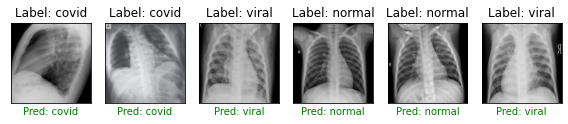

In [12]:
images, labels = next(iter(train_dataloader))
show_images(images, labels, labels)

## 4. Model

In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [15]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet18.parameters(), lr=3e-5)

In [16]:
def show_preds(model, dataloader, device):
    model.to(device)
    model.eval()
    (images, labels) = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

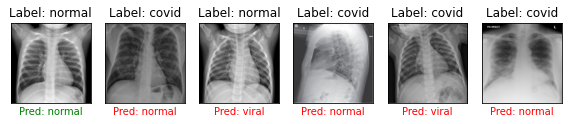

In [18]:
show_preds(resnet18, test_dataloader, device)

## 5. Training

In [19]:
def train(epochs, model, device,
          train_dataloader, test_dataloader,
          train_dataset, test_dataset,
          optimizer, criterion):
    print('Starting training..')
    for epoch in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {epochs + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        model.train()
        model.to(device)
        
        for train_step, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if (train_step % 20) == 0:
                print('Evaluating at step', train_step)
                accuracy = 0.
                val_loss = 0.
                model.eval()
                
                for val_step, (images, labels) in enumerate(test_dataloader):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels))
                    
                val_loss /= (val_step + 1)
                accuracy /= len(test_dataset)
                print(f'Validation loss: {val_loss:.4f}\nAccuracy: {accuracy:.4f}')
                show_preds(model, test_dataloader, device)
                
                model.train()
                
                if accuracy > 0.95:
                    print('Performance condition satisfied..')
                    return
                
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')

Starting training..
Starting epoch 2/1
Evaluating at step 0
Validation loss: 1.5247
Accuracy: 0.2222


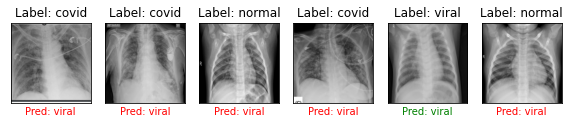

Evaluating at step 20
Validation loss: 0.8326
Accuracy: 0.6778


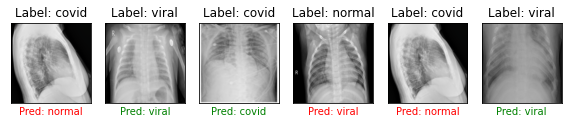

Evaluating at step 40
Validation loss: 0.5479
Accuracy: 0.8556


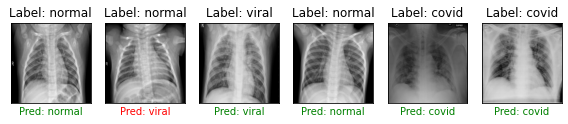

Evaluating at step 60
Validation loss: 0.3116
Accuracy: 0.9222


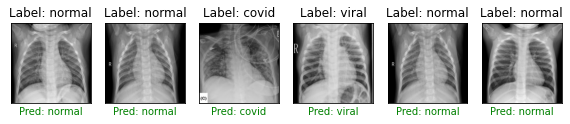

Evaluating at step 80
Validation loss: 0.2861
Accuracy: 0.9222


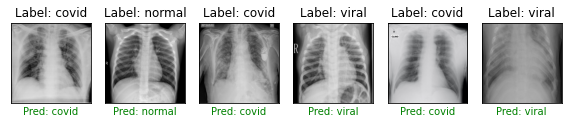

Evaluating at step 100


In [ ]:
train(epochs=1, 
      model=resnet18,
      device=device,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      train_dataset=train_dataset,
      test_dataset=test_dataset,
      optimizer=optimizer,
      criterion=criterion)

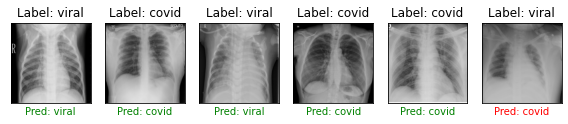

In [20]:
show_preds(model=resnet18,
           dataloader=test_dataloader,
           device=device)